## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp032'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3), #IAAPiecewiseAffine
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

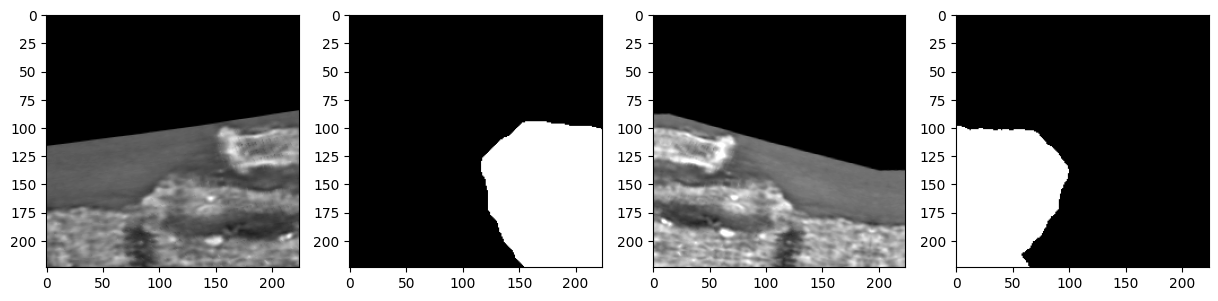

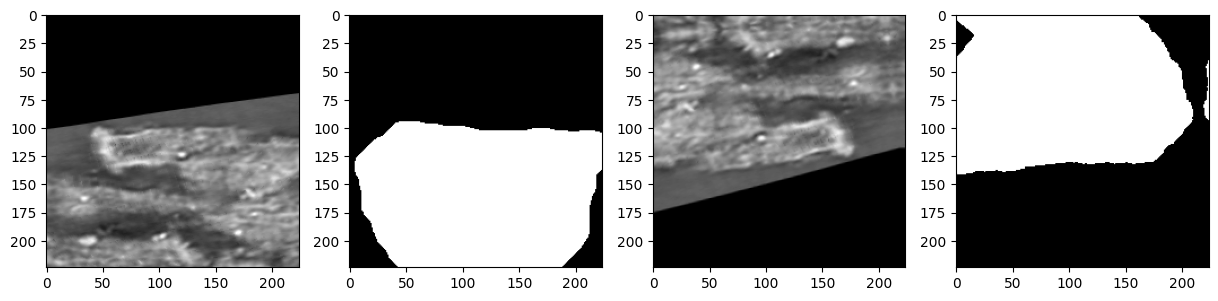

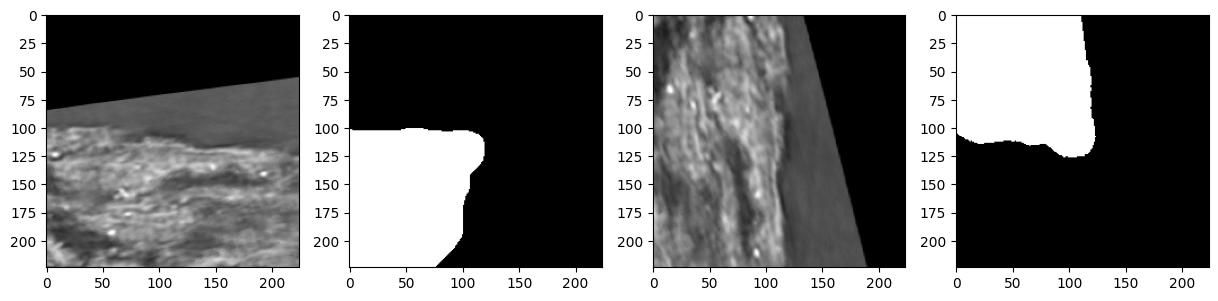

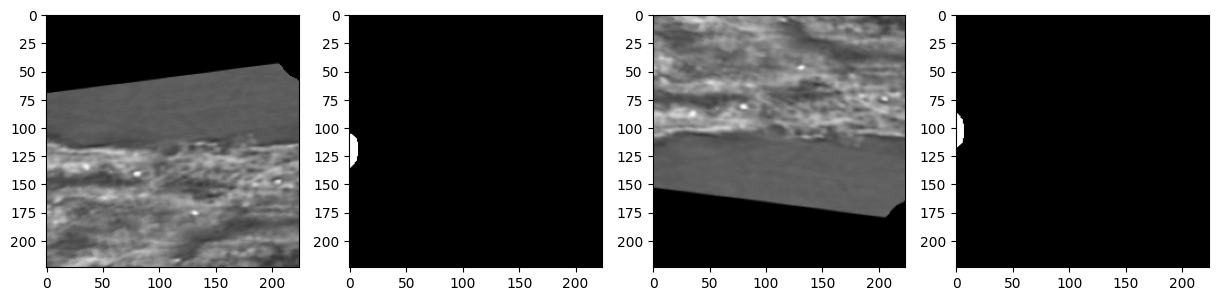

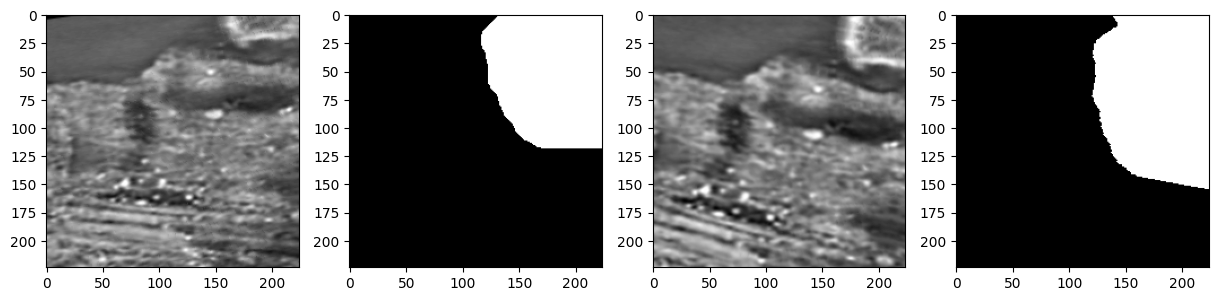

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

53895

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:
class FBetaLoss(nn.Module):
    def __init__(self, smooth: float = 1e-6, beta: float = 0.5):
        super().__init__()
        self.smooth = smooth
        self.beta = beta

    def forward(self, pred: torch.Tensor, true: torch.Tensor):
        pred_prob = torch.sigmoid(pred)
        if true.sum() == 0 and pred_prob.sum() == 0:
            return 0.0
        y_true_count = true.sum()
        ctp = (pred_prob * true).sum()
        cfp = (pred_prob * (1 - true)).sum()
        beta_squared = self.beta * self.beta

        c_precision = ctp / (ctp + cfp + self.smooth)
        c_recall = ctp / (y_true_count + self.smooth)
        fbeta = (
            (1 + beta_squared)
            * (c_precision * c_recall)
            / (beta_squared * c_precision + c_recall + self.smooth)
        )

        return 1 - fbeta

In [30]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()
FBetaLoss_ = FBetaLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * FBetaLoss_(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    # return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [31]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [32]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [33]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [34]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14208560944873078
th: 0.15, fbeta: 0.14205490074667362
th: 0.2, fbeta: 0.14192453006518682
th: 0.25, fbeta: 0.14192834229212747
th: 0.3, fbeta: 0.19522567310945035
th: 0.35, fbeta: 0.2145034049913557
th: 0.4, fbeta: 0.23057405869048014
th: 0.45, fbeta: 0.24236698533096143


best_th: 0.5, fbeta: 0.25151098944454436
Epoch 1 - avg_train_loss: 0.7835  avg_val_loss: 0.6960  time: 116s
Epoch 1 - avgScore: 0.2515
Epoch 1 - Save Best Score: 0.2515 Model
Epoch 1 - Save Best Loss: 0.6960 Model


th: 0.5, fbeta: 0.25151098944454436


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209214329793246
th: 0.15, fbeta: 0.1420918557331209
th: 0.2, fbeta: 0.14597594042598147
th: 0.25, fbeta: 0.20674480407169377
th: 0.3, fbeta: 0.24111528127275406
th: 0.35, fbeta: 0.2747829405371284
th: 0.4, fbeta: 0.3067243787935731
th: 0.45, fbeta: 0.3233042785835807


best_th: 0.45, fbeta: 0.3233042785835807
Epoch 2 - avg_train_loss: 0.6741  avg_val_loss: 0.6439  time: 120s
Epoch 2 - avgScore: 0.3233
Epoch 2 - Save Best Score: 0.3233 Model
Epoch 2 - Save Best Loss: 0.6439 Model


th: 0.5, fbeta: 0.31856766888161264


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:728: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.3293110607206879
th: 0.15, fbeta: 0.3423068139013512
th: 0.2, fbeta: 0.33025013718193513
th: 0.25, fbeta: 0.3079980280156603
th: 0.3, fbeta: 0.28167041595701003
th: 0.35, fbeta: 0.24763135947780082
th: 0.4, fbeta: 0.21331242978491283
th: 0.45, fbeta: 0.17997353274756378


best_th: 0.15, fbeta: 0.3423068139013512
Epoch 3 - avg_train_loss: 0.5454  avg_val_loss: 0.6012  time: 121s
Epoch 3 - avgScore: 0.3423
Epoch 3 - Save Best Score: 0.3423 Model
Epoch 3 - Save Best Loss: 0.6012 Model


th: 0.5, fbeta: 0.14564056570278205


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12767056188684442
th: 0.15, fbeta: 0.08468711818922378
th: 0.2, fbeta: 0.06231201216534406
th: 0.25, fbeta: 0.047788769388092345
th: 0.3, fbeta: 0.03737983013503295
th: 0.35, fbeta: 0.028534778928799538
th: 0.4, fbeta: 0.02047084321785009
th: 0.45, fbeta: 0.01401447366952943


best_th: 0.1, fbeta: 0.12767056188684442
Epoch 4 - avg_train_loss: 0.4358  avg_val_loss: 0.7053  time: 121s
Epoch 4 - avgScore: 0.1277


th: 0.5, fbeta: 0.00964342609883139


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3419494656552244
th: 0.15, fbeta: 0.31329071747495113
th: 0.2, fbeta: 0.29138012707812555
th: 0.25, fbeta: 0.26706437029289365
th: 0.3, fbeta: 0.24398439566006994
th: 0.35, fbeta: 0.22143397639086504
th: 0.4, fbeta: 0.19956939335863777
th: 0.45, fbeta: 0.17358715388537294


best_th: 0.1, fbeta: 0.3419494656552244
Epoch 5 - avg_train_loss: 0.3890  avg_val_loss: 0.6737  time: 119s
Epoch 5 - avgScore: 0.3419


th: 0.5, fbeta: 0.15071186324469366


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26057042207581343
th: 0.15, fbeta: 0.2475208665023542
th: 0.2, fbeta: 0.23148168300700986
th: 0.25, fbeta: 0.20059258812999828
th: 0.3, fbeta: 0.1763545874680951
th: 0.35, fbeta: 0.16317720834120908
th: 0.4, fbeta: 0.151448700729719
th: 0.45, fbeta: 0.13364351546386274


best_th: 0.1, fbeta: 0.26057042207581343
Epoch 6 - avg_train_loss: 0.3588  avg_val_loss: 0.7345  time: 119s
Epoch 6 - avgScore: 0.2606


th: 0.5, fbeta: 0.110424128706339


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.318916779204546
th: 0.15, fbeta: 0.31103809611080563
th: 0.2, fbeta: 0.30151755805823016
th: 0.25, fbeta: 0.27806598277128103
th: 0.3, fbeta: 0.2522676076635867
th: 0.35, fbeta: 0.23859086083616915
th: 0.4, fbeta: 0.22479441036748188
th: 0.45, fbeta: 0.199823313892979


best_th: 0.1, fbeta: 0.318916779204546
Epoch 7 - avg_train_loss: 0.3472  avg_val_loss: 0.7117  time: 122s
Epoch 7 - avgScore: 0.3189


th: 0.5, fbeta: 0.16562025795928947


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3551132112942415
th: 0.15, fbeta: 0.33927314320137214
th: 0.2, fbeta: 0.32042628992603095
th: 0.25, fbeta: 0.29398986040011094
th: 0.3, fbeta: 0.2715460129838774
th: 0.35, fbeta: 0.2521229032445844
th: 0.4, fbeta: 0.2324225592814702
th: 0.45, fbeta: 0.2085674532550007


best_th: 0.1, fbeta: 0.3551132112942415
Epoch 8 - avg_train_loss: 0.3254  avg_val_loss: 0.7187  time: 121s
Epoch 8 - avgScore: 0.3551
Epoch 8 - Save Best Score: 0.3551 Model
Epoch 8 - Save Best Loss: 0.7187 Model


th: 0.5, fbeta: 0.17682109230508464


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23110384051764854
th: 0.15, fbeta: 0.21348037807936077
th: 0.2, fbeta: 0.19757747090671082
th: 0.25, fbeta: 0.1711138889711254
th: 0.3, fbeta: 0.15261383628226027
th: 0.35, fbeta: 0.13780922382751615
th: 0.4, fbeta: 0.1257579414035338
th: 0.45, fbeta: 0.10929451042109817


best_th: 0.1, fbeta: 0.23110384051764854
Epoch 9 - avg_train_loss: 0.3063  avg_val_loss: 0.7982  time: 125s
Epoch 9 - avgScore: 0.2311


th: 0.5, fbeta: 0.08856721019666476


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3294781948979601
th: 0.15, fbeta: 0.3136354387975273
th: 0.2, fbeta: 0.29762945386907963
th: 0.25, fbeta: 0.2692059869733746
th: 0.3, fbeta: 0.2456741106146865
th: 0.35, fbeta: 0.2291612007268243
th: 0.4, fbeta: 0.21546546222794263
th: 0.45, fbeta: 0.19754082591892705


best_th: 0.1, fbeta: 0.3294781948979601
Epoch 10 - avg_train_loss: 0.2912  avg_val_loss: 0.7369  time: 121s
Epoch 10 - avgScore: 0.3295


th: 0.5, fbeta: 0.16428321414438668


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38815908847657
th: 0.15, fbeta: 0.37759141801661317
th: 0.2, fbeta: 0.36828670480147346
th: 0.25, fbeta: 0.3563848809771926
th: 0.3, fbeta: 0.33394219752816384
th: 0.35, fbeta: 0.3150299749714497
th: 0.4, fbeta: 0.30077863505583696
th: 0.45, fbeta: 0.28554088422579926


best_th: 0.1, fbeta: 0.38815908847657
Epoch 11 - avg_train_loss: 0.2834  avg_val_loss: 0.7051  time: 120s
Epoch 11 - avgScore: 0.3882
Epoch 11 - Save Best Score: 0.3882 Model
Epoch 11 - Save Best Loss: 0.7051 Model


th: 0.5, fbeta: 0.2545878337742079


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3956243263871457
th: 0.15, fbeta: 0.39381092737497553
th: 0.2, fbeta: 0.39276814792449827
th: 0.25, fbeta: 0.38636179784350616
th: 0.3, fbeta: 0.3786932108756137
th: 0.35, fbeta: 0.3724257625666493
th: 0.4, fbeta: 0.3652669198721895
th: 0.45, fbeta: 0.34963455227900314


best_th: 0.1, fbeta: 0.3956243263871457
Epoch 12 - avg_train_loss: 0.2754  avg_val_loss: 0.6942  time: 122s
Epoch 12 - avgScore: 0.3956
Epoch 12 - Save Best Score: 0.3956 Model
Epoch 12 - Save Best Loss: 0.6942 Model


th: 0.5, fbeta: 0.3268224588120617


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3914597775683615
th: 0.15, fbeta: 0.3838621541576865
th: 0.2, fbeta: 0.377632676943241
th: 0.25, fbeta: 0.3612613057961402
th: 0.3, fbeta: 0.3417063763209098
th: 0.35, fbeta: 0.3293265936820429
th: 0.4, fbeta: 0.3188261354236725
th: 0.45, fbeta: 0.29799578014126804


best_th: 0.1, fbeta: 0.3914597775683615
Epoch 13 - avg_train_loss: 0.2475  avg_val_loss: 0.7431  time: 122s
Epoch 13 - avgScore: 0.3915


th: 0.5, fbeta: 0.26070299689712245


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3859374718791355
th: 0.15, fbeta: 0.3749498704304159
th: 0.2, fbeta: 0.3655874643229472
th: 0.25, fbeta: 0.3489441464961052
th: 0.3, fbeta: 0.3275936732020152
th: 0.35, fbeta: 0.31010514908556874
th: 0.4, fbeta: 0.29690448112810547
th: 0.45, fbeta: 0.2786952618979967


best_th: 0.1, fbeta: 0.3859374718791355
Epoch 14 - avg_train_loss: 0.2342  avg_val_loss: 0.7368  time: 119s
Epoch 14 - avgScore: 0.3859


th: 0.5, fbeta: 0.24882060989044508


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26511548498807513
th: 0.15, fbeta: 0.24354860436142114
th: 0.2, fbeta: 0.22398208935874966
th: 0.25, fbeta: 0.19465665125196313
th: 0.3, fbeta: 0.17276408813563154
th: 0.35, fbeta: 0.15695386514362378
th: 0.4, fbeta: 0.14347779189729593
th: 0.45, fbeta: 0.12478521876262791


best_th: 0.1, fbeta: 0.26511548498807513
Epoch 15 - avg_train_loss: 0.2219  avg_val_loss: 0.8332  time: 120s
Epoch 15 - avgScore: 0.2651


th: 0.5, fbeta: 0.09753473092721779


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3722952452679748
th: 0.15, fbeta: 0.36443513493203555
th: 0.2, fbeta: 0.35486954038248
th: 0.25, fbeta: 0.33506501636310604
th: 0.3, fbeta: 0.31699482510536464
th: 0.35, fbeta: 0.30402984184216986
th: 0.4, fbeta: 0.29273971721075903
th: 0.45, fbeta: 0.27465952244144376


best_th: 0.1, fbeta: 0.3722952452679748
Epoch 16 - avg_train_loss: 0.2153  avg_val_loss: 0.8124  time: 120s
Epoch 16 - avgScore: 0.3723


th: 0.5, fbeta: 0.23791294361841234


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.308148721488129
th: 0.15, fbeta: 0.2949566809649626
th: 0.2, fbeta: 0.28465688162818925
th: 0.25, fbeta: 0.2582641797139246
th: 0.3, fbeta: 0.23393928249923926
th: 0.35, fbeta: 0.21990971609412824
th: 0.4, fbeta: 0.2090262217115169
th: 0.45, fbeta: 0.19377011819504936


best_th: 0.1, fbeta: 0.308148721488129
Epoch 17 - avg_train_loss: 0.2049  avg_val_loss: 0.8218  time: 120s
Epoch 17 - avgScore: 0.3081


th: 0.5, fbeta: 0.16383970563958025


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2683264549810671
th: 0.15, fbeta: 0.2600668373028883
th: 0.2, fbeta: 0.25083544096622695
th: 0.25, fbeta: 0.226521703878374
th: 0.3, fbeta: 0.20445403077801802
th: 0.35, fbeta: 0.19502931214621536
th: 0.4, fbeta: 0.18635923453320283
th: 0.45, fbeta: 0.17016983553317672


best_th: 0.1, fbeta: 0.2683264549810671
Epoch 18 - avg_train_loss: 0.1940  avg_val_loss: 0.8451  time: 119s
Epoch 18 - avgScore: 0.2683


th: 0.5, fbeta: 0.1379053731964073


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3264729577401983
th: 0.15, fbeta: 0.31391524400894255
th: 0.2, fbeta: 0.30149969355119316
th: 0.25, fbeta: 0.2766912840556368
th: 0.3, fbeta: 0.25283399650790284
th: 0.35, fbeta: 0.24046527008784677
th: 0.4, fbeta: 0.22957041058490782
th: 0.45, fbeta: 0.21337657234966179


best_th: 0.1, fbeta: 0.3264729577401983
Epoch 19 - avg_train_loss: 0.1837  avg_val_loss: 0.8154  time: 119s
Epoch 19 - avgScore: 0.3265


th: 0.5, fbeta: 0.17956062448568047


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3929531380756639
th: 0.15, fbeta: 0.39063769175781266
th: 0.2, fbeta: 0.38842564778593097
th: 0.25, fbeta: 0.38172219653159944
th: 0.3, fbeta: 0.3701818578411982
th: 0.35, fbeta: 0.36226308985415434
th: 0.4, fbeta: 0.3550482134763129
th: 0.45, fbeta: 0.34296509681769627


best_th: 0.1, fbeta: 0.3929531380756639
Epoch 20 - avg_train_loss: 0.1813  avg_val_loss: 0.7662  time: 120s
Epoch 20 - avgScore: 0.3930


th: 0.5, fbeta: 0.31903725613032025


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3839786182864781
th: 0.15, fbeta: 0.3798043755751976
th: 0.2, fbeta: 0.37521211826294576
th: 0.25, fbeta: 0.36450108573879747
th: 0.3, fbeta: 0.34848285349940655
th: 0.35, fbeta: 0.33574516603684995
th: 0.4, fbeta: 0.3241792470294772
th: 0.45, fbeta: 0.3090614327616602


best_th: 0.1, fbeta: 0.3839786182864781
Epoch 21 - avg_train_loss: 0.1737  avg_val_loss: 0.7801  time: 120s
Epoch 21 - avgScore: 0.3840


th: 0.5, fbeta: 0.28311814329251145


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3036523763597859
th: 0.15, fbeta: 0.29274585917655016
th: 0.2, fbeta: 0.2802210149103922
th: 0.25, fbeta: 0.2520228876398094
th: 0.3, fbeta: 0.22501028784846563
th: 0.35, fbeta: 0.20916711317377862
th: 0.4, fbeta: 0.1960131327708756
th: 0.45, fbeta: 0.17650578852576626


best_th: 0.1, fbeta: 0.3036523763597859
Epoch 22 - avg_train_loss: 0.1703  avg_val_loss: 0.8805  time: 120s
Epoch 22 - avgScore: 0.3037


th: 0.5, fbeta: 0.14369116455765626


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34412210100007345
th: 0.15, fbeta: 0.3333977754518895
th: 0.2, fbeta: 0.3224087469026848
th: 0.25, fbeta: 0.29749015553168634
th: 0.3, fbeta: 0.2680563925055377
th: 0.35, fbeta: 0.2528026020249628
th: 0.4, fbeta: 0.24143228481560816
th: 0.45, fbeta: 0.22648072936564465


best_th: 0.1, fbeta: 0.34412210100007345
Epoch 23 - avg_train_loss: 0.1494  avg_val_loss: 0.8539  time: 120s
Epoch 23 - avgScore: 0.3441


th: 0.5, fbeta: 0.19475927256527964


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31256145336640523
th: 0.15, fbeta: 0.30049187534652577
th: 0.2, fbeta: 0.28891640304560473
th: 0.25, fbeta: 0.2587818352037225
th: 0.3, fbeta: 0.2231631972939588
th: 0.35, fbeta: 0.20960017739412357
th: 0.4, fbeta: 0.1993664658018825
th: 0.45, fbeta: 0.18544326680274145


best_th: 0.1, fbeta: 0.31256145336640523
Epoch 24 - avg_train_loss: 0.1497  avg_val_loss: 0.8729  time: 121s
Epoch 24 - avgScore: 0.3126


th: 0.5, fbeta: 0.15005751362664244


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36299159791921826
th: 0.15, fbeta: 0.3548025072893721
th: 0.2, fbeta: 0.34702918728383003
th: 0.25, fbeta: 0.32805934463681846
th: 0.3, fbeta: 0.3038350208827333
th: 0.35, fbeta: 0.289271917771789
th: 0.4, fbeta: 0.27815484753489184
th: 0.45, fbeta: 0.26341909313558765


best_th: 0.1, fbeta: 0.36299159791921826
Epoch 25 - avg_train_loss: 0.1432  avg_val_loss: 0.8507  time: 120s
Epoch 25 - avgScore: 0.3630


th: 0.5, fbeta: 0.23152501726509778


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31901442577558314
th: 0.15, fbeta: 0.3048324436379579
th: 0.2, fbeta: 0.29243872616764355
th: 0.25, fbeta: 0.2645085062751908
th: 0.3, fbeta: 0.23633065327943853
th: 0.35, fbeta: 0.22112403105966225
th: 0.4, fbeta: 0.2095773997489538
th: 0.45, fbeta: 0.19353190327320496


best_th: 0.1, fbeta: 0.31901442577558314
Epoch 26 - avg_train_loss: 0.1407  avg_val_loss: 0.8874  time: 120s
Epoch 26 - avgScore: 0.3190


th: 0.5, fbeta: 0.15814898343112477


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3422099847494085
th: 0.15, fbeta: 0.33014220384573145
th: 0.2, fbeta: 0.3198731162693997
th: 0.25, fbeta: 0.2946279084803087
th: 0.3, fbeta: 0.2684734193857828
th: 0.35, fbeta: 0.2542154829026618
th: 0.4, fbeta: 0.24271034279082682
th: 0.45, fbeta: 0.22669757754296987


best_th: 0.1, fbeta: 0.3422099847494085
Epoch 27 - avg_train_loss: 0.1389  avg_val_loss: 0.8523  time: 120s
Epoch 27 - avgScore: 0.3422


th: 0.5, fbeta: 0.19237037565275095


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31748566574177783
th: 0.15, fbeta: 0.30405424274091947
th: 0.2, fbeta: 0.29228274828236545
th: 0.25, fbeta: 0.26544131675426674
th: 0.3, fbeta: 0.23752496618992963
th: 0.35, fbeta: 0.22088727490995103
th: 0.4, fbeta: 0.20867558356844326
th: 0.45, fbeta: 0.19345546919377235


best_th: 0.1, fbeta: 0.31748566574177783
Epoch 28 - avg_train_loss: 0.1365  avg_val_loss: 0.8828  time: 120s
Epoch 28 - avgScore: 0.3175


th: 0.5, fbeta: 0.16150651954646206


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30888751439175804
th: 0.15, fbeta: 0.29753429647449803
th: 0.2, fbeta: 0.2869791816318299
th: 0.25, fbeta: 0.2591037291559046
th: 0.3, fbeta: 0.23141361065738605
th: 0.35, fbeta: 0.21618436813275355
th: 0.4, fbeta: 0.20532904131345445
th: 0.45, fbeta: 0.19074306812019595


best_th: 0.1, fbeta: 0.30888751439175804
Epoch 29 - avg_train_loss: 0.1302  avg_val_loss: 0.8825  time: 121s
Epoch 29 - avgScore: 0.3089


th: 0.5, fbeta: 0.15920627956572123


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27934541805083857
th: 0.15, fbeta: 0.2673358858948236
th: 0.2, fbeta: 0.25567416873497956
th: 0.25, fbeta: 0.22584943105385805
th: 0.3, fbeta: 0.19501002722262947
th: 0.35, fbeta: 0.17983422431791857
th: 0.4, fbeta: 0.1684497218253143
th: 0.45, fbeta: 0.15298947545132968


best_th: 0.1, fbeta: 0.27934541805083857
Epoch 30 - avg_train_loss: 0.1317  avg_val_loss: 0.9134  time: 120s
Epoch 30 - avgScore: 0.2793


th: 0.5, fbeta: 0.11691773405467835


In [35]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [36]:
mask_pred = check_point['preds']

In [37]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3956243263871457
th: 0.15, fbeta: 0.39381092737497553
th: 0.2, fbeta: 0.39276814792449827
th: 0.25, fbeta: 0.38636179784350616
th: 0.3, fbeta: 0.3786932108756137
th: 0.35, fbeta: 0.3724257625666493
th: 0.4, fbeta: 0.3652669198721895
th: 0.45, fbeta: 0.34963455227900314


best_th: 0.1, fbeta: 0.3956243263871457


th: 0.5, fbeta: 0.3268224588120617


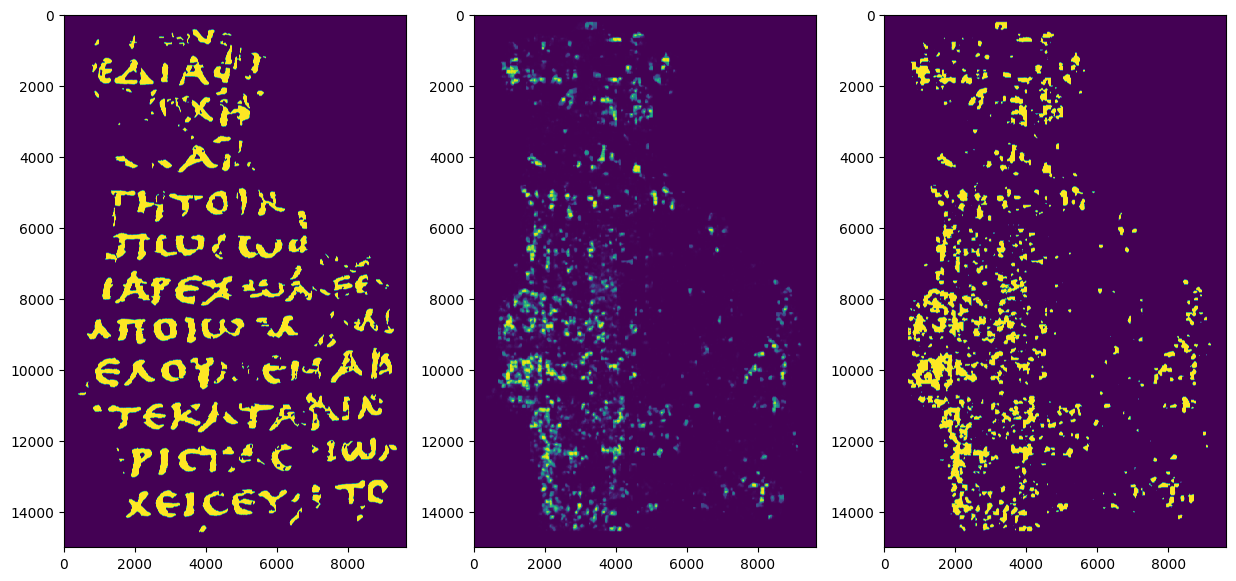

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.30156412e+08, 3.39655700e+06, 1.32050300e+06, 1.14730300e+06,
        1.47154900e+06, 9.68103000e+05, 5.93775000e+05, 5.85651000e+05,
        7.84226000e+05, 7.31177000e+05, 4.22551000e+05, 3.08334000e+05,
        3.37519000e+05, 3.69568000e+05, 2.91803000e+05, 2.38064000e+05,
        2.96059000e+05, 4.01072000e+05, 4.47334000e+05, 2.89496000e+05]),
 array([4.21124095e-06, 4.99043991e-02, 9.98045869e-02, 1.49704775e-01,
        1.99604963e-01, 2.49505150e-01, 2.99405338e-01, 3.49305526e-01,
        3.99205714e-01, 4.49105902e-01, 4.99006090e-01, 5.48906277e-01,
        5.98806465e-01, 6.48706653e-01, 6.98606841e-01, 7.48507029e-01,
        7.98407217e-01, 8.48307405e-01, 8.98207592e-01, 9.48107780e-01,
        9.98007968e-01]),
 <BarContainer object of 20 artists>)

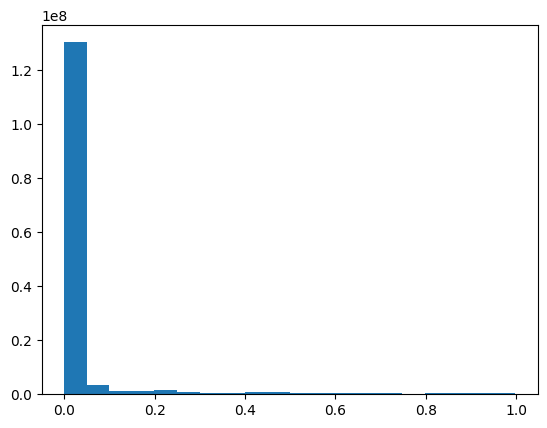

In [39]:
plt.hist(mask_pred.flatten(), bins=20)

In [40]:
# GPU VRAM 5.2GB/16.0GB A4000